In [1]:
import os
import glob
from collections import OrderedDict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pysam

# Summary

In [7]:
runs = ["UMI_100", "UMI_200", "4CL", "9CL"]
array = []

for run in runs:
    d = OrderedDict()
    
    total_reads = int(open("results/demux/read_count/%s.txt" % run).readlines()[0].strip())
    d["TotalReads"] = total_reads
    
    cell_reads = 0
    for path in glob.glob("results/demux/pychopper/%s/*.log" % run):
        for line in open(path):
            if "Total fastq records in input file:" in line:
                cell_reads += int(line.strip().split()[-1])
    d["CellReads"] = cell_reads
    d["CellRatio"] = cell_reads / total_reads
    
    trim_reads = 0
    polya_reads = 0
    if False:
        for path in glob.glob("results/demux/cutadapt/%s/*.log" % run):
            for line in open(path):
                if "Total reads processed:" in line:
                    trim_reads += int(line.strip().split()[-1].replace(",", ""))
                elif "Reads written (passing filters):" in line:
                    polya_reads += int(line.strip().split()[-2].replace(",", ""))
    else:
        for path in glob.glob("results/demux/remove_polya/%s/*.log" % run):
            lines = open(path).readlines()
            trim_reads += int(lines[0].strip().split()[-1])
            polya_reads += int(lines[1].strip().split()[-1])
    d["TrimReads"] = trim_reads
    d["TrimRatio"] = trim_reads / total_reads
    d["PolyAReads"] = polya_reads
    d["PolyARatio"] = polya_reads / total_reads
    
    mapped = 0
    for path in glob.glob("results/mapping/minimap2/%s/*.flagstat" % run):
        with open(path) as f:
            for line in f:
                if "primary mapped" in line:
                    mapped += int(line.split()[0])
    d["MappedReads"] = mapped
    d["MappedRatio"] = mapped / total_reads
    
    filtered = 0
    for path in glob.glob("results/mapping/filtered/%s/*.flagstat" % run):
        with open(path) as f:
            for line in f:
                if "primary mapped" in line:
                    filtered += int(line.split()[0])
    d["FilteredReads"] = filtered
    d["FilteredRatio"] = filtered / total_reads
    
    clip_filtered = 0
    for path in glob.glob("results/mapping/stat_clip/%s/*.flagstat" % run):
        with open(path) as f:
            for line in f:
                if "primary mapped" in line:
                    clip_filtered += int(line.split()[0])
    d["ClipFilteredReads"] = clip_filtered
    d["ClipFilteredRatio"] = clip_filtered / total_reads
                    
    array.append(d)
    
d = pd.DataFrame(array, index=pd.Index(runs, name="Sample"))
d

,TotalReads,CellReads,CellRatio,TrimReads,TrimRatio,PolyAReads,PolyARatio,MappedReads,MappedRatio,FilteredReads,FilteredRatio,ClipFilteredReads,ClipFilteredRatio
Sample,,,,,,,,,,,,,
UMI_100,47209842,32608563,0.690715,29478501,0.624414,23314319,0.493844,22473015,0.476024,17984524,0.380949,11493639,0.243459
UMI_200,47419955,28084696,0.592255,25959503,0.547438,21036074,0.443612,20169902,0.425346,15993658,0.337277,9139230,0.192730
4CL,84610428,68262224,0.806783,67711367,0.800272,56859164,0.672011,54485905,0.643962,45166458,0.533817,36918876,0.436340
9CL,84801426,61465620,0.724818,60759551,0.716492,48542253,0.572423,46231110,0.545169,36456706,0.429907,27676309,0.326366


TotalRatio       100.000000
CellRatio         70.364276
TrimRatio         67.215422
PolyARatio        54.547266
MappedRatio       52.262533
FilteredRatio     42.048725
dtype: float64
TotalRatio        0.000000
CellRatio         8.880809
TrimRatio        10.986838
PolyARatio        9.963155
MappedRatio       9.463213
FilteredRatio     8.449762
dtype: float64


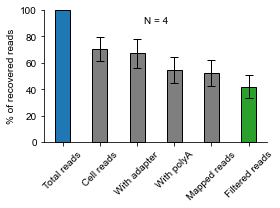

In [22]:
m = d[["CellRatio", "TrimRatio", "PolyARatio", "MappedRatio", "FilteredRatio", "ClipFilteredRatio"]].copy()
m["TotalRatio"] = 1
m = m[["TotalRatio", "CellRatio", "TrimRatio", "PolyARatio", "MappedRatio", "FilteredRatio"]] * 100

ys = m.mean()
yerr = m.std()
xs = np.arange(len(ys))
colors = ["C0", "C7", "C7", "C7", "C7", "C2"]
ticks = ["Total reads", "Cell reads", "With adapter", "With polyA", "Mapped reads", "Filtered reads"]
print(ys)
print(yerr)

plt.figure(figsize=(4, 3))
plt.bar(xs, ys, yerr=yerr, edgecolor="black", color=colors, width=0.4,
        error_kw={"capsize": 4, "linewidth": 1}, clip_on=False)
plt.text(2.5, 90, "N = 4", ha="center")
plt.xlim(-0.5, 5.5)
plt.xticks(xs, ticks, rotation=45)
plt.ylim(0, 100)
plt.ylabel("% of recovered reads")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.tight_layout()
plt.savefig("figures/nascseq2_filter_propotion.pdf", dpi=300)

# Make results/UMI_100_K562.bam

In [5]:
table = pd.read_excel("data/Supplementary_Table_S1_Summary_of_sequenced_cells.xlsx")
d = table[table["Library"] == "UMI_100"]
d = d[d["Organism"] == "Human"]

paths = []
for run, cell in d[["Library", "Rename"]].values:
    path = "results/mapping/filtered/%s/%s.bam" % (run, cell)
    paths.append(path)
outfile = "results/UMI_100_K562.bam"

cmd = "samtools merge -@ 8 -o %s %s" % (outfile, " ".join(paths))
assert os.system(cmd) == 0

cmd = "samtools index %s" % outfile
assert os.system(cmd) == 0